In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw
import random
import csv

This block lists all files and directories under /kaggle/input. It helps in understanding the dataset structure and confirming the path to the data files.

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/trashcan-segmentation-public/sample_submission.csv
/kaggle/input/trashcan-segmentation-public/val-without_segmentation.json
/kaggle/input/trashcan-segmentation-public/train.json
/kaggle/input/trashcan-segmentation-public/val/vid_000115_frame0000041.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000265_frame0000006.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000139_frame0000009.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000031_frame0000032.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000023_frame0000014.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000085_frame0000027.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000021_frame0000035.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000043_frame0000014.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000152_frame0000028.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000143_frame0000059.jpg
/kaggle/input/trashcan-segmentation-public/val/vid_000142_

Loads JSON annotations for both training and validation datasets. These annotations contain essential data such as image IDs and segmentation information for the training images.

In [3]:
train_images = '/kaggle/input/trashcan-segmentation-public/train/train'  
train_json = '/kaggle/input/trashcan-segmentation-public/train.json'

val_images = '/kaggle/input/trashcan-segmentation-public/val'  
val_json = '/kaggle/input/trashcan-segmentation-public/val-without_segmentation.json'

with open(train_json, 'r') as f:
    train_annotations = json.load(f)
    
with open(val_json, 'r') as f:
    val_annotations = json.load(f)

In [4]:
def dataset_shape(images_dir):

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    num_images = len(image_files)
    
    first_image = Image.open(os.path.join(images_dir, image_files[0]))
    image_size = first_image.size
    print(num_images, image_size)
    
print("Train dataset shape:")
dataset_shape(train_images)

print("Test dataset shape:")
dataset_shape(val_images)

Train dataset shape:
6065 (480, 270)
Test dataset shape:
1147 (480, 270)


These functions are used to both visualize training images with their corresponding segmentation polygons drawn over them and validation images. 

In [5]:
def draw_polygons_on_image(image, polygons):
    """
    Draws polygons on an image.
    Args:
    - image (PIL.Image): The image on which to draw.
    - polygons (list of np.array): List of polygons (each polygon is np.array of points).
    Returns:
    - PIL.Image: Image with polygons drawn on it with alpha transparency.
    
    """
    rgba_image = Image.new("RGBA", image.size)
    draw = ImageDraw.Draw(rgba_image)
    for polygon in polygons:
        points = tuple(map(tuple, polygon))  
        draw.polygon(points, outline=(255,0,255,255), fill=((255,0,255,128)))
    
    combined = Image.alpha_composite(image.convert("RGBA"), rgba_image)
    return combined.convert('RGBA')

def visualize_images(images_dir, annotations=None):
    """
    Args:
    - images_dir (str): Directory containing the images.
    - annotations (dict): The loaded annotations from the json file.
    """
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  
    axs = axs.flatten()

    image_ids = [image['id'] for image in annotations['images']]
    chosen_ids = np.random.choice(image_ids, 6, replace=False)

    for ax, image_id in zip(axs, chosen_ids):
        image_info = next(item for item in annotations['images'] if item['id'] == image_id)
        image_path = os.path.join(images_dir, image_info['file_name'])
        image = Image.open(image_path)
        
        if 'annotations' in annotations:
            segmentation_polygons = []
            for ann in annotations['annotations']:
                if ann['image_id'] == image_id:
                    for polygon in ann['segmentation']:
                        segmentation_polygons.append(np.array(polygon).reshape(-1, 2))

            image = draw_polygons_on_image(image, segmentation_polygons)
            
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Train Images with segmentations


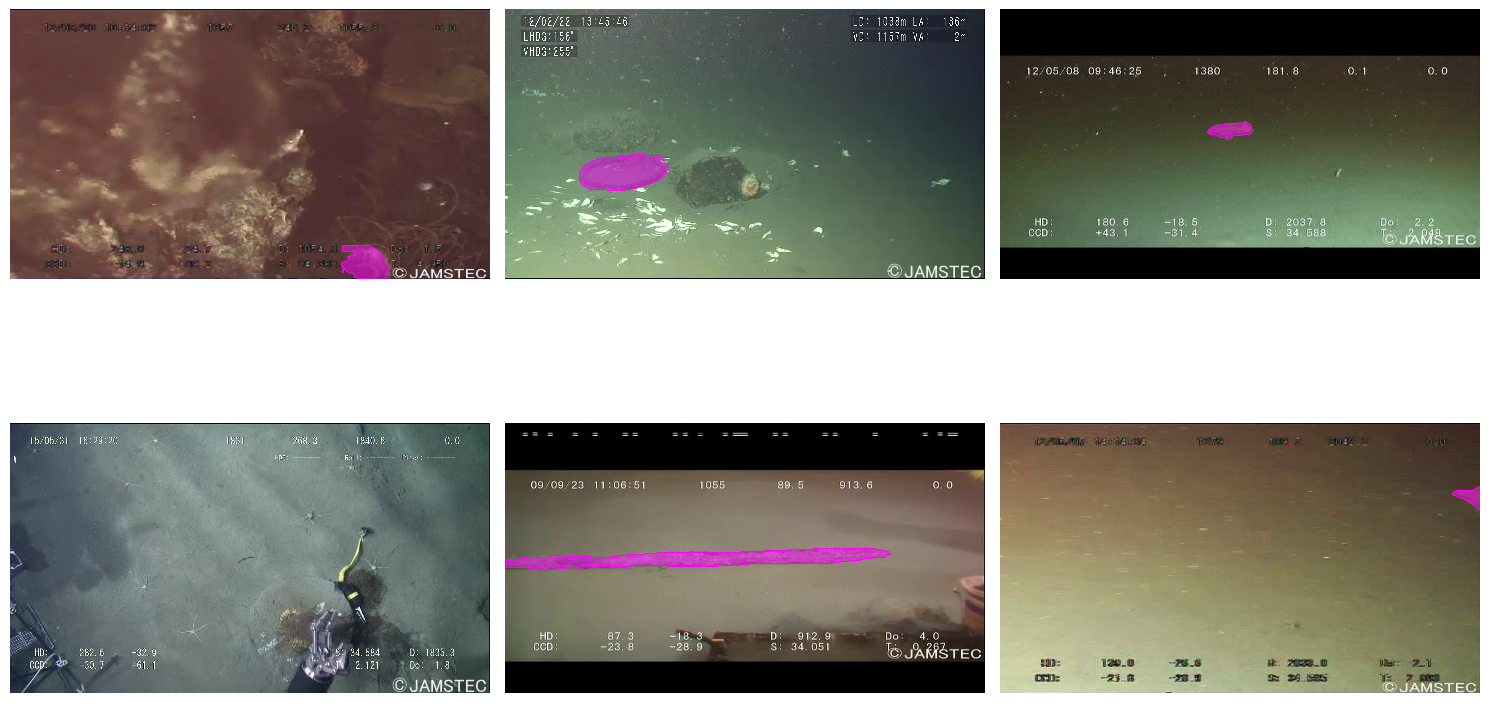

In [6]:
print('Train Images with segmentations')
visualize_images(train_images, train_annotations)

Val Images


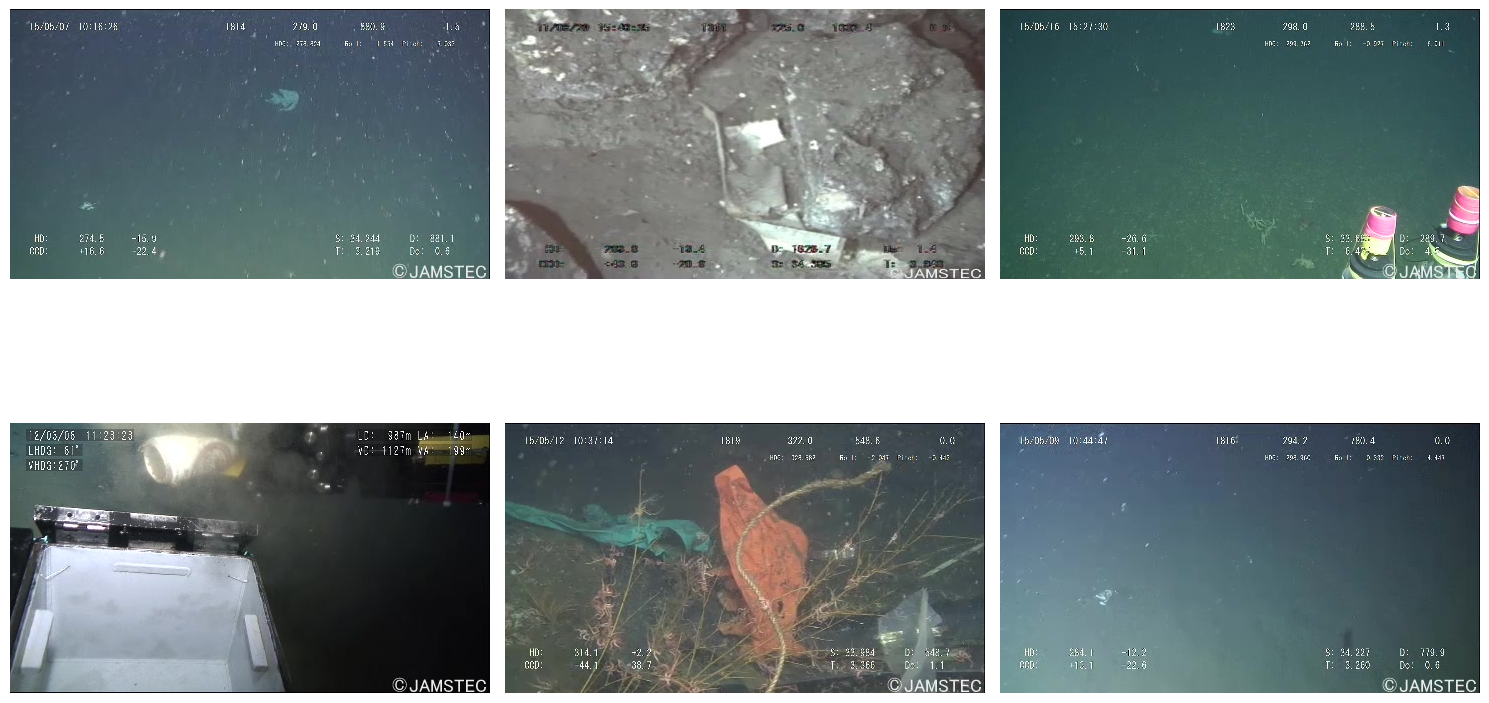

In [7]:
print('Val Images')
visualize_images(val_images, val_annotations)

Great! After visualizing our training and validation images, the next step is to start working on the segmentation model. As a starting point, for the sample submission on Kaggle, we can implement a simple function that creates a mask with a single random circle drawn on it. The circle's center and radius are chosen randomly within the bounds of the image. To accommodate the requirement that some images contain no trash and must have a blank mask, we also modify the mask generation process so that there is a certain probability (for example, 10%) that an blank mask is generated. This will allow to establish a baseline and ensure that our submission pipeline works correctly before implementing more sophisticated models.

In [8]:
def create_random_circle_mask(image_size):

    mask = Image.new('L', image_size, 0)  
    draw = ImageDraw.Draw(mask)
    radius = np.random.randint(20, min(image_size)//4)  
    x = np.random.randint(radius, image_size[0] - radius)
    y = np.random.randint(radius, image_size[1] - radius)
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=1)
    return np.array(mask)

Lets visualize random masks (filled circles) on 6 random validation images, and see what we have.

Val Images with Random Masks


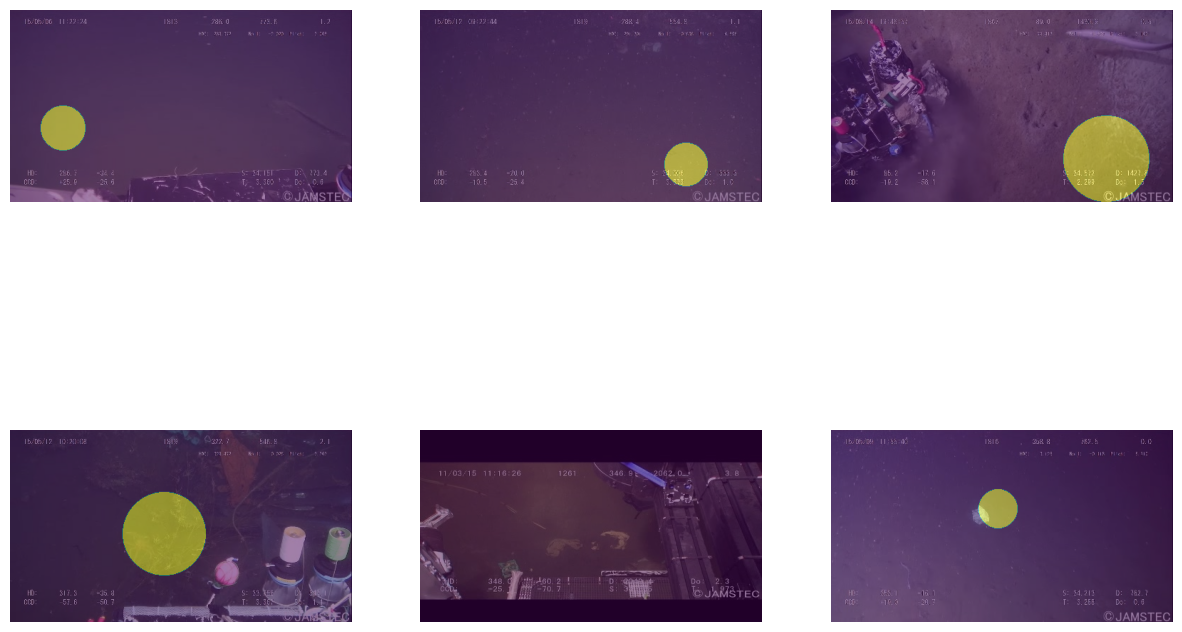

In [9]:
def visualize_val_images_with_masks(val_images_dir):
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()
    image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]
    selected_images = np.random.choice(image_files, 6, replace=False)

    for ax, img_file in zip(axs, selected_images):
        img_path = os.path.join(val_images_dir, img_file)
        image = Image.open(img_path)
        if random.random() < 0.1:  
            mask = np.zeros((image.height, image.width), dtype=np.uint8)
        else:
            mask = create_random_circle_mask(image.size)
        mask_image = Image.fromarray((mask * 255).astype('uint8')) 

        ax.imshow(image)
        ax.imshow(mask_image, cmap='viridis', alpha=0.5)  
        
        ax.axis('off')
    plt.show()

print('Val Images with Random Masks')
visualize_val_images_with_masks(val_images)

The competition uses run-length encoding to encode the binary predictions and evaluate solutions. Below, we give functions needed to convert your segmentations into the needed format. 

Mainly, the prepare_submission function generates a submission file by applying random masks to validation images and encoding these masks using run_length_encode. It handles cases where some images might intentionally not have masks to simulate correct "no object" predictions.

In [10]:
def run_length_encode(mask):
    
    pixel_values = mask.flatten()
    encoded_values = []
    current_pixel = pixel_values[0]
    count = 1

    for pixel in pixel_values[1:]:
        if pixel == current_pixel:
            count += 1
        else:
            encoded_values.extend([current_pixel, count])
            current_pixel = pixel
            count = 1

    
    encoded_values.extend([current_pixel, count])
    return encoded_values

In [11]:
image_id_map = {item['file_name']: item['id'] for item in val_annotations['images']}

In [12]:
def create_submission(val_images_dir, image_id_map, output_file="sample_submission.csv"):
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_id', 'Mask'])

        for img_file, img_id in image_id_map.items():
            img_path = os.path.join(val_images_dir, img_file)
            image = Image.open(img_path)
            
            if random.random() < 0.1:  
                mask = np.zeros((image.height, image.width), dtype=np.uint8) 
            else:
                mask = create_random_circle_mask(image.size)
    
            encoded_mask = run_length_encode(mask)
            writer.writerow([img_id, ' '.join(map(str, encoded_mask))])

print("Preparing submission...")
create_submission(val_images, image_id_map)
print("Submission is ready.")

Preparing submission...
Submission is ready.
